# Search for the order Scleractinia and extract all records below.

In [1]:
import json
from urllib.request import urlopen
import urllib.parse
import pandas as pd

Searching the order [Scleractinia](https://www.marinespecies.org/aphia.php?p=taxdetails&id=1363) and drill down to all species. 

**AphiaID** 1363  (urn:lsid:marinespecies.org:taxname:1363) 

Collect all the AphiaIDs for the families associated with [Scleractinia](https://www.marinespecies.org/aphia.php?p=taxdetails&id=1363)

Need to follow the Taxonomy Classification from order down:
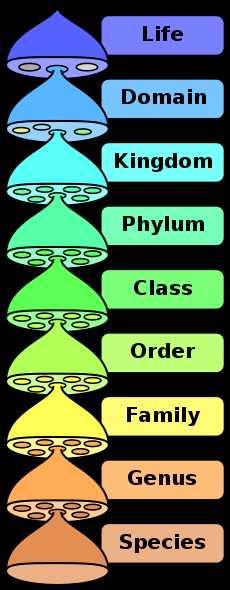

Turns out we can simply search OBIS using the AphiaID for the **order** `Scleractinia` and it will return all appropriate records.

Let's replicate this response from OBIS mapper https://mapper.obis.org/?taxonid=1363#

To do:
* figure out years
* figure out species
* figure out taxa

In [2]:
base = 'https://api.obis.org/v3/'

aphiaID = '1363'
size = 1

# define a polygon
# bound it to between 30 deg N and S latitude
geometry=urllib.parse.quote("POLYGON ((-180 -30, 180 -30, 180 30, -180 30, -180 -30))")

# identify start and end depth
startdepth = 0
enddepth = 30

occurrence_id = 'occurrence?taxonid={}&startdepth={}&enddepth={}&geometry={}&size={}'.format(aphiaID,startdepth,enddepth,geometry,size)

# build the api query and print out the number of records found
url = '{}{}'.format(base,occurrence_id)
response= urlopen(url)
data_json = json.loads(response.read())
size = data_json['total']

print("Found %i records." % size)
print("See in mapper at: %s" % '{}{}#'.format('https://mapper.obis.org/?',occurrence_id.replace("occurrence?","")))

Found 435054 records.
See in mapper at: https://mapper.obis.org/?taxonid=1363&startdepth=0&enddepth=30&geometry=POLYGON%20%28%28-180%20-30%2C%20180%20-30%2C%20180%2030%2C%20-180%2030%2C%20-180%20-30%29%29&size=1#


Now let's query the OBIS API for the observations matching the criteria defined above and return select fields from all the records.

In [13]:
data = pd.DataFrame() # initialize df

# build a list of the subset of fields you want back
fields = ['dataset_id','datasetID','id','decimalLatitude','decimalLongitude','species','aphiaID','date_year']

f = "%2C".join([f"{v}" for v in fields])


# The API limits responses to 10,000 entries, so we need to iterate by 10k and use the last occurrence
# uuid to set after "Occurrence UUID up to which to skip."
for i in range(10000,size,10000):
    if i == 10000:
        # build url for first call
        occurrence_id = 'occurrence?taxonid={}&startdepth={}&enddepth={}&geometry={}&fields={}&size=10000'.format(aphiaID,startdepth,enddepth,geometry,f)
    else:
        # build url for remaining calls
        uuid = data.iloc[-1]['id']
        occurrence_id = 'occurrence?taxonid={}&startdepth={}&enddepth={}&geometry={}&fields={}&after={}&size=10000'.format(aphiaID,startdepth,enddepth,geometry,f,uuid)
        
    url = '{}{}'.format(base,occurrence_id)
    # open the api call
    response= urlopen(url) 
    # read in the json
    data_json = json.loads(response.read())
    # build a mongo dataframe with all results
    data = pd.concat([data, pd.DataFrame(data_json['results'])])
    
    print('Data shape:',len(data_json['results']),data.shape)
    
    # kick out of loop at the end
    if len(data_json['results']) < 10000:
        break

# Need to grab from last iteration to expected size.
uuid = data.iloc[-1]['id']
occurrence_id = 'occurrence?taxonid={}&startdepth={}&enddepth={}&geometry={}&fields={}&after={}&size=10000'.format(aphiaID,startdepth,enddepth,geometry,f,uuid)
url = '{}{}'.format(base,occurrence_id)
response= urlopen(url)
data_json = json.loads(response.read())
data_json['results']
data = pd.concat([data, pd.DataFrame(data_json['results'])])
print('Data shape:',len(data_json['results']),data.shape)        

print('Final shape:',data.shape)

Data shape: 10000 (10000, 8)
Data shape: 10000 (20000, 8)
Data shape: 10000 (30000, 8)
Data shape: 10000 (40000, 8)
Data shape: 10000 (50000, 8)
Data shape: 10000 (60000, 8)
Data shape: 10000 (70000, 8)
Data shape: 10000 (80000, 8)
Data shape: 10000 (90000, 8)
Data shape: 10000 (100000, 8)
Data shape: 10000 (110000, 8)
Data shape: 10000 (120000, 8)
Data shape: 10000 (130000, 8)
Data shape: 10000 (140000, 8)
Data shape: 10000 (150000, 8)
Data shape: 10000 (160000, 8)
Data shape: 10000 (170000, 8)
Data shape: 10000 (180000, 8)
Data shape: 10000 (190000, 8)
Data shape: 10000 (200000, 8)
Data shape: 10000 (210000, 8)
Data shape: 10000 (220000, 8)
Data shape: 10000 (230000, 8)
Data shape: 10000 (240000, 8)
Data shape: 10000 (250000, 8)
Data shape: 10000 (260000, 8)
Data shape: 10000 (270000, 8)
Data shape: 10000 (280000, 8)
Data shape: 10000 (290000, 8)
Data shape: 10000 (300000, 8)
Data shape: 10000 (310000, 8)
Data shape: 10000 (320000, 8)
Data shape: 10000 (330000, 8)
Data shape: 10000 (

In [38]:
df_group = data.groupby(by='datasetID')
df_group['dataset_id'].count()

datasetID
ANLA:1271:2014                              6
ANLA:1293:2013                             63
CREMPDryTortugas1999                       37
CREMPDryTortugas2000                       36
CREMPDryTortugas2001                       38
                                         ... 
https://marineinfo.org/id/dataset/3128    187
https://marineinfo.org/id/dataset/4542    299
https://marineinfo.org/id/dataset/6458      4
https://marineinfo.org/id/dataset/6656      1
https://marineinfo.org/id/dataset/961     310
Name: dataset_id, Length: 75, dtype: int64

In [51]:
for entry in data['dataset_id'].dropna().unique():
    if len(data.loc[data['dataset_id']==entry, 'datasetID'].unique()) > 1:
        print('dataset_id =',data.loc[data['dataset_id']==entry, 'dataset_id'].unique())
        print('datasetID =',data.loc[data['dataset_id']==entry, 'datasetID'].unique())

dataset_id = ['4bbfb75e-7b41-4f8f-b475-051d8c21860a']
datasetID = ['INVEMAR:SIMAC:2011' 'INVEMAR:SIMAC:2004' 'INVEMAR:SIMAC:2006'
 'INVEMAR:SIMAC:2002' 'INVEMAR:SIMAC:2000' 'INVEMAR:SIMAC:2010'
 'INVEMAR:SIMAC:2007' 'INVEMAR:SIMAC:2001' 'INVEMAR:SIMAC:2009'
 'INVEMAR:SIMAC:2008' 'INVEMAR:SIMAC:2012' 'INVEMAR:SIMAC:2003'
 'INVEMAR:SIMAC:2017' 'INVEMAR:SIMAC:1998' 'INVEMAR:SIMAC:1997'
 'INVEMAR:SIMAC:2005' 'INVEMAR:SIMAC:1995' 'INVEMAR:SIMAC:1999'
 'INVEMAR:SIMAC:2013' 'INVEMAR:SIMAC:1996' 'INVEMAR:SIMAC:2018'
 'INVEMAR:SIMAC:1994']
dataset_id = ['f5a4799e-dc24-4807-89d9-01da47d52e3b']
datasetID = ['NMNH_IZ' 'NOAA_DFH-32-33' 'NOAA_NF-18-04']


In [47]:
data.loc[data['datasetID']==entry, 'dataset_id'].unique()

array(['f5a4799e-dc24-4807-89d9-01da47d52e3b'], dtype=object)

In [11]:
print("records:",data.shape[0])
print("Years: %i - %i" % (data["date_year"].astype(float).min(),data["date_year"].astype(float).max()))
print("Species:", len(data['species'].dropna().unique()))
print("Taxa:", len(data['aphiaID'].dropna().unique()))
print("Datasets:", len(data['dataset_id'].dropna().unique()))

records: 435054
Years: 1874 - 2021
Species: 823
Taxa: 951
Datasets: 125


In [ ]:
## Just pulling the coordinates
# base = 'https://api.obis.org/v3/'

# aphiaID = '1363'

# occurrence_points = 'occurrence/points?taxonid={}&startdepth={}&enddepth={}&geometry={}'.format(aphiaID,startdepth,enddepth,geometry)
# url = '{}{}'.format(base,occurrence_points)
# response= urlopen(url)
# data_json = json.loads(response.read())
# data = pd.DataFrame(data_json['coordinates'])
# data.shape

Make the histogram of occurrences

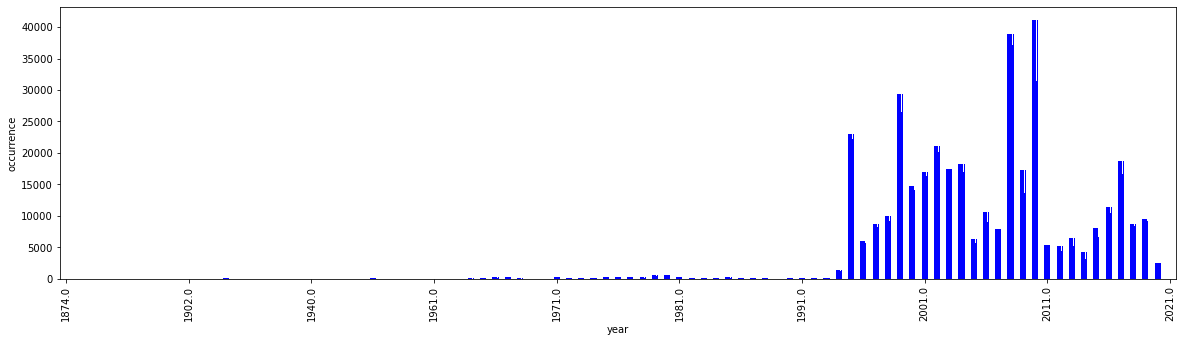

In [5]:
import matplotlib as plt

data['date'] = pd.to_datetime(data['date_year'],format="%Y")

year_group = data.groupby(data['date'].dt.year)

ax = year_group.count().plot(kind="bar", 
                             color='blue',
                             legend=False, 
                             figsize=(20, 5),
                             ylabel='occurrence',
                             xlabel='year',
                            )

ax.xaxis.set_major_locator(plt.ticker.MaxNLocator(10))

What is our maximum occurrence count in one year?

In [ ]:
year_group['date_year'].count().max()

This jives with the OBIS mapper!

Now create a GeoDataFrame to perform GIS actions easier.

In [6]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude),
    crs="EPSG:4326")

Now bin the GeoDataFrame to 1 degree cells using the example at https://james-brennan.github.io/posts/fast_gridding_geopandas/.

In [7]:
import numpy as np
import shapely

# total area for the grid
xmin, ymin, xmax, ymax= [-180., -90., 180., 90]

# how many cells across and down
n_cells = 360

# calculate the size of the cells
cell_size = (xmax-xmin)/n_cells

# create an evenly distributed GeoDataFrame for the grid described above
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
        
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs="EPSG:4326")
    
# spatial join the OBIS data with the one-degree cells for where OBIS data are within cells.
merged = gpd.sjoin(gdf, cell, how='left', op='within')

# make a simple count variable that we can sum for each cell
merged['n_occur'] = 1

# Compute stats per grid cell -- aggregate occurences to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")

# put this into cell
cell.loc[dissolve.index, 'n_occur'] = dissolve.n_occur.values

# calculate occurrence density in km^2 for each cell.
cell['area (km2)'] = cell.to_crs(epsg=3763).area/(1000**2)

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Make a map using geoplot

## 7A

C:\Users\MATHEW~1.BID\AppData\Local\Temp\11/ipykernel_17416/752472083.py:43: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(True)
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packag

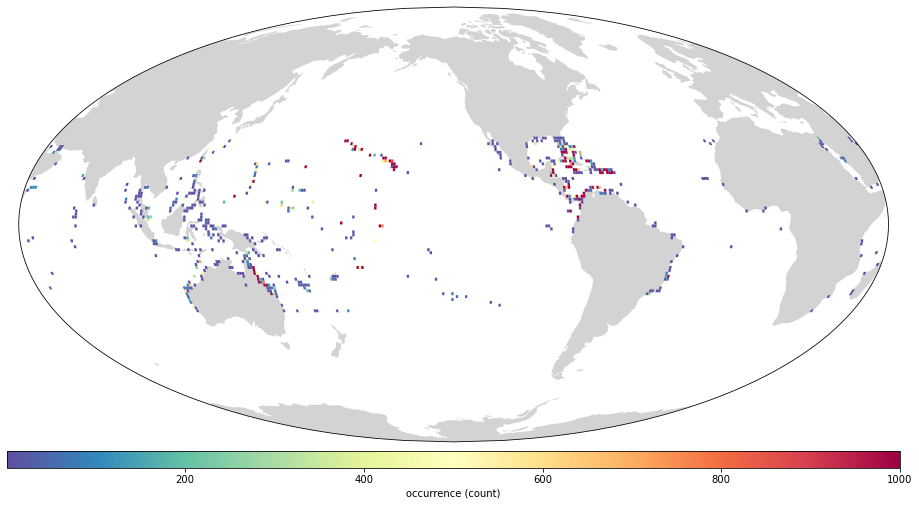

In [9]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mpl.colors.Normalize(vmin=1, vmax=1000)

projection=gcrs.Mollweide(central_longitude=-130)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(16,8), facecolor=None, subplot_kw={'projection':projection})

geoplot.polyplot(
    world.dissolve(),
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
    ax=ax,
)

cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])

cell = cell[~cell['n_occur'].isna()] # drop all NaN cells - makes plotting quicker.

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Spectral_r',
                   legend=True,
                   legend_kwargs={'orientation': 'horizontal',
                                  'cax':cax,
                                  'label':"occurrence (count)",
                                 },
                   norm=norm, 
                  )

ax.set_global(); 

ax.outline_patch.set_visible(True)

Add the global distribution of coral reefs in tropical and subtropical regions from https://data.unep-wcmc.org/datasets/1 using WMS services from https://gis.unep-wcmc.org/arcgis/services/marine/WCMC_008_CoralReefs_WMS/MapServer/WMSServer?request=GetCapabilities&service=WMS

## 7B

Focus the extent of the map on the Gulf of Mexico region.

C:\Users\MATHEW~1.BID\AppData\Local\Temp\11/ipykernel_17416/2901299717.py:89: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(True)
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:347: S

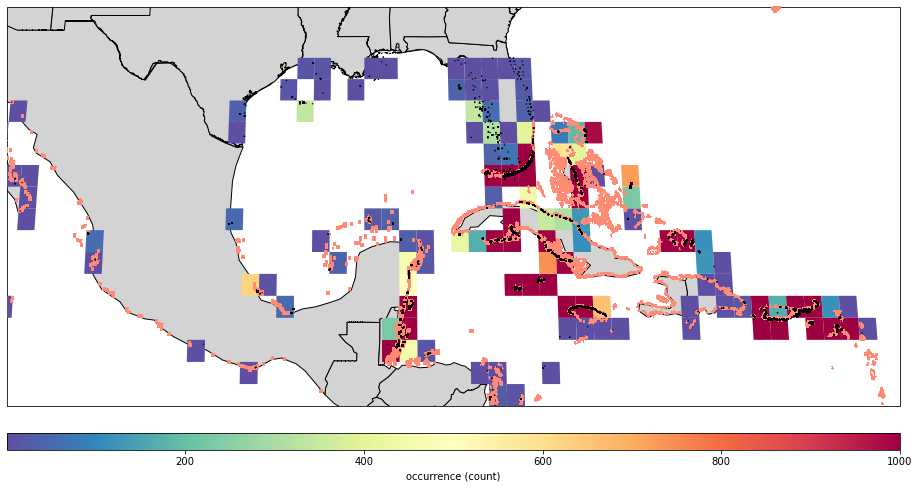

In [10]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature

norm = mpl.colors.Normalize(vmin=1, vmax=1000)


projection=gcrs.Mollweide(central_longitude=-90)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

continental_usa = gpd.read_file('./data/cb_2018_us_state_500k.shp')

fig, ax = plt.subplots(figsize=(16,8), facecolor=None, subplot_kw={'projection':projection})

geoplot.polyplot(
    world,
    facecolor='lightgray',
    edgecolor='black',
    projection=projection,
    ax=ax,
    zorder=1,
)

geoplot.polyplot(
    continental_usa,
    facecolor='lightgray',
    edgecolor='black',
    projection=projection,
    ax=ax,
    zorder=2,
)

cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Spectral_r',
                   legend=True,
                   legend_kwargs={'orientation': 'horizontal',
                                  'cax':cax,
                                  'label':"occurrence (count)",
                                 },
                   norm=norm, 
                   zorder=3,
                  )

# ax.set_global(); 

# order = [0,2,1,3]
# pull extent from existing data
# extent = [gdf_dist1.total_bounds[i] for i in order]

# or define your own as a list [xmin, xmax, ymin, ymax]
extent = [-110, -60, 14, 30]

ax.set_extent(extent)

ax.add_wms(wms='https://gis.unep-wcmc.org/arcgis/services/marine/WCMC_008_CoralReefs_WMS/MapServer/WMSServer?request=GetCapabilities&service=WMS',
          layers=['0','1'],
          zorder=5,
          )

def identity_scale(minval, maxval):
    def scalar(val):
        return 0.5
    return scalar

geoplot.pointplot(
    gdf,
    scale=gdf.index,
    scale_func=identity_scale,
    color='black',
    edgecolor=None,
    projection=projection,
    zorder=10,
    ax=ax,
)

ax.set_extent(extent)

ax.outline_patch.set_visible(True)

# ax.text(-82.49747 28.62844, 'Florida', 
#                 transform=ccrs.Geodetic(), 
#                 zorder=11, 
#                 fontdict={'fontweight':'semibold'},
#                 #bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'),
#        )

# ax.text(-66.46502, 18.22203, 'Puerto Rico',
#                 transform=ccrs.Geodetic(), 
#                 zorder=11, 
#                 fontdict={'fontweight':'semibold'},
#                 #bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'),
#        )

# ax.text(-64.80205 17.96902, 'United States Virgin Islands',
#                 transform=ccrs.Geodetic(), 
#                 zorder=11, 
#                 fontdict={'fontweight':'semibold'},
#                 #bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'),
#        )

## 7C

Focus the extent of the map on the U.S. Pacific Islands

C:\Users\MATHEW~1.BID\AppData\Local\Temp\11/ipykernel_17416/562432318.py:71: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(True)
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packag

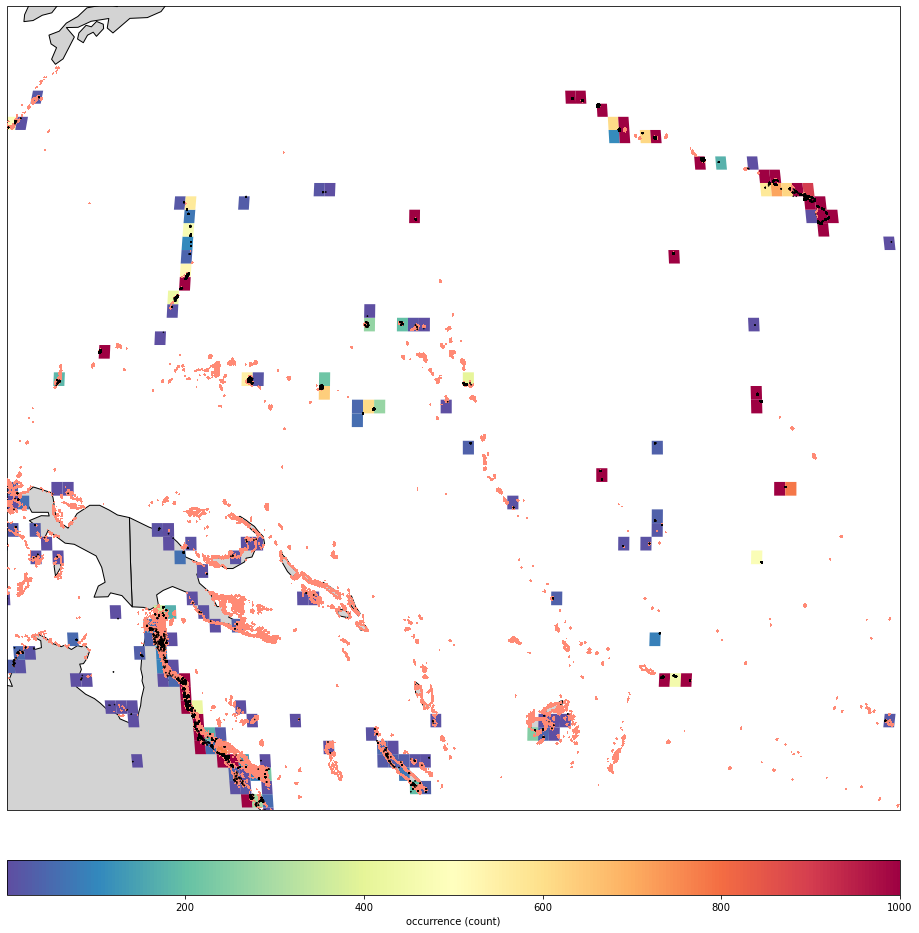

In [11]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mpl.colors.Normalize(vmin=1, vmax=1000)


projection=gcrs.Mollweide(central_longitude=-189)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(16,16), facecolor=None, subplot_kw={'projection':projection})

geoplot.polyplot(
    world,
    facecolor='lightgray',
    edgecolor='black',
    projection=projection,
    ax=ax,
    zorder=1,
)


cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Spectral_r',
                   legend=True,
                   legend_kwargs={'orientation': 'horizontal',
                                  'cax':cax,
                                  'label':"occurrence (count)",
                                 },
                   norm=norm, 
                   zorder=2,
                  )

# define your own as a list [xmin, xmax, ymin, ymax]
extent = [-230, -149, -19, 29]

ax.set_extent(extent)

ax.add_wms(wms='https://gis.unep-wcmc.org/arcgis/services/marine/WCMC_008_CoralReefs_WMS/MapServer/WMSServer?request=GetCapabilities&service=WMS',
          layers=['0','1'],
          zorder=5,
          )

def identity_scale(minval, maxval):
    def scalar(val):
        return 0.5
    return scalar

geoplot.pointplot(
    gdf,
    scale=gdf.index,
    scale_func=identity_scale,
    color='black',
    edgecolor=None,
    projection=projection,
    zorder=10,
    ax=ax,
)

ax.set_extent(extent)

ax.outline_patch.set_visible(True)

# ax.text(-156.36302, 20.25471, 'Hawaii', 
#                 transform=ccrs.Geodetic(), 
#                 zorder=11, 
#                 fontdict={'fontweight':'semibold'},
#                 #bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'),
#        )

# ax.text(144.77415, 13.44376, 'Guam',
#                 transform=ccrs.Geodetic(), 
#                 zorder=11, 
#                 fontdict={'fontweight':'semibold'},
#                 #bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'),
#        )

# ax.text(-170.36961, -14.22008, 'American Samoa',
#                 transform=ccrs.Geodetic(), 
#                 zorder=11, 
#                 fontdict={'fontweight':'semibold'},
#                 #bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'),
#        )

## Make it one figure w/ subplots

In [ ]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

def identity_scale(minval, maxval):
    def scalar(val):
        return 0.5
    return scalar

wms = 'https://gis.unep-wcmc.org/arcgis/services/marine/WCMC_008_CoralReefs_WMS/MapServer/WMSServer?request=GetCapabilities&service=WMS'

norm = mpl.colors.Normalize(vmin=1, vmax=1000)

projection=gcrs.Mollweide(central_longitude=-130)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(16,20), facecolor=None, subplot_kw={'projection':projection})

# making top subplot span 2 cols
gs = ax[0, 1].get_gridspec()
# remove the underlying axes
for a in ax[0, :]:
    a.remove()
ax0 = fig.add_subplot(gs[0, :], projection=projection)
ax1 = ax[1,0]
ax2 = ax[1,1]


geoplot.polyplot(
    world.dissolve(),
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
    ax=ax0,
)

cell = cell[~cell['n_occur'].isna()] # drop all NaN cells - makes plotting quicker.

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax0,
                   cmap='Spectral_r',
                   legend=False,
                   norm=norm, 
                  )

ax0.set_global(); 

ax0.outline_patch.set_visible(True)

# New subplot for carribean

projection=gcrs.Mollweide(central_longitude=-90)

geoplot.polyplot(
    world,
    facecolor='lightgray',
    edgecolor='black',
    projection=projection,
    ax=ax1,
)

# or define your own as a list [xmin, xmax, ymin, ymax]
extent = [-110, -60, 14, 30]

ax1.set_extent(extent)

ax1.add_wms(wms=wms,
          layers=['0','1'],
          zorder=5,
          )

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax1,
                   cmap='Spectral_r',
                   legend=False,
                   norm=norm, 
                   zorder=2,
                  )

geoplot.pointplot(
    gdf,
    scale=gdf.index,
    scale_func=identity_scale,
    color='black',
    edgecolor=None,
    projection=projection,
    zorder=10,
    ax=ax1,
)

ax1.set_extent(extent)

ax1.outline_patch.set_visible(True)

# New subplot for Pacific region

projection=gcrs.Mollweide(central_longitude=-189)

geoplot.polyplot(
    world,
    facecolor='lightgray',
    edgecolor='black',
    projection=projection,
    ax=ax2,
)

# define your own as a list [xmin, xmax, ymin, ymax]
extent = [-230, -149, -19, 29]

ax2.set_extent(extent)

ax2.add_wms(wms=wms,
          layers=['0','1'],
          zorder=5,
          )

cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax2,
                   cmap='Spectral_r',
                   legend=True,
                   legend_kwargs={'orientation': 'horizontal',
                                  'cax':cax,
                                  'label':"occurrence (count)",
                                 },
                   norm=norm, 
                   zorder=2,
                  )

geoplot.pointplot(
    gdf,
    scale=gdf.index,
    scale_func=identity_scale,
    color='black',
    edgecolor=None,
    projection=projection,
    zorder=10,
    ax=ax2,
)

ax2.set_extent(extent)

ax2.outline_patch.set_visible(True)

#fig.tight_layout()

## Now let's look at some statistics on the number of occurrences per cell:

Make a latitudinal histogram

In [ ]:
bins = [i for i in range(-90, 91, 1)]

data.hist(column='decimalLatitude', bins=bins, orientation='horizontal')

Combine the latitude histogram with the map to recreate this figure https://bbest.github.io/obis-lat-time-fig/#map,_hist,_time-series_combined

**To do:** link histogram y axis with map latitude lines.

In [ ]:
import geoplot
import geoplot.crs as gcrs
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


norm = mpl.colors.Normalize(vmin=1, vmax=1000)

projection=gcrs.Mollweide(central_longitude=-160)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.dissolve()

fig, ax = plt.subplots(figsize=(16,8), facecolor='white', subplot_kw={'projection':projection})

geoplot.polyplot(
    world,
    figsize=(16,8),
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
    ax=ax,
)


cax = fig.add_axes([0.225, 0.08, 0.575, 0.03])


# drop na cells
cell = cell[~cell['n_occur'].isna()]

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Spectral_r',
                   legend=True,
                   legend_kwargs={'orientation': 'horizontal',
                                  'cax':cax,
                                  'label':"occurrence (count)",
                                 },
                   norm=norm, 
                  )

ax.set_global(); ax.outline_patch.set_visible(True); 

gl = ax.gridlines(draw_labels=True)
gl.ylocator = mticker.FixedLocator([-90, -75, -50, -25, 0, 25, 50, 75, 90])

ax2 = fig.add_axes([0.91, 0.1257, 0.03, 0.7555])

bins = [i for i in range(-90, 91, 1)]


# count, lat = pd.np.histogram(data['decimalLatitude'], bins=bins)

# ynums = np.linspace(ax.yaxis.get_data_interval()[0],ax.yaxis.get_data_interval()[1],179)

# ax2.plot(count,ynums)
# ax2.sharey(ax)
# ax2.axes.get_yaxis().set_visible(False)

data.hist(column='decimalLatitude', bins=bins, orientation='horizontal', ax=ax2, )
# plt.title('')